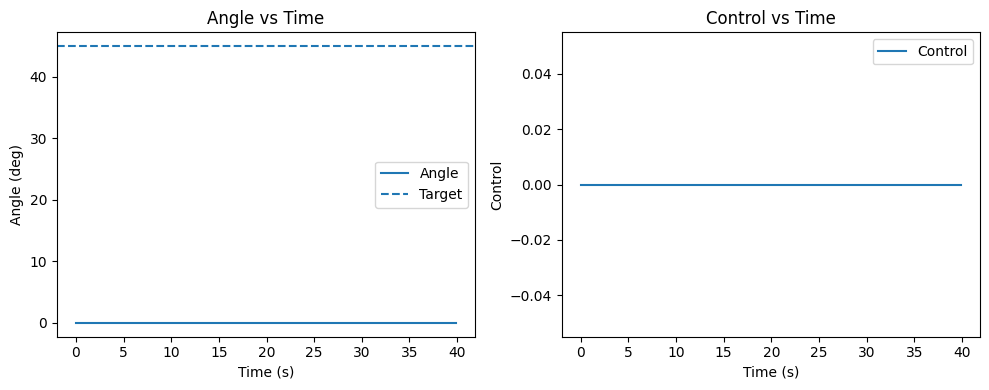

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utility: triangular membership ----------
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)

# ---------- Define fuzzy sets as lambdas ----------
def err_neg(x): return trimf(x, -30, -30, 0)
def err_zero(x): return trimf(x, -10, 0, 10)
def err_pos(x): return trimf(x, 0, 30, 30)

def derr_neg(x): return trimf(x, -10, -10, 0)
def derr_zero(x): return trimf(x, -3, 0, 3)
def derr_pos(x): return trimf(x, 0, 10, 10)

# Control output universe for defuzzification
u_universe = np.linspace(-20, 20, 401)

# Membership functions for control (same shapes as before)
def u_sn(x): return trimf(x, -20, -20, -10)
def u_wn(x): return trimf(x, -15, -7, 0)
def u_z(x):  return trimf(x, -3, 0, 3)
def u_wp(x): return trimf(x, 0, 7, 15)
def u_sp(x): return trimf(x, 10, 20, 20)

# ---------- Rule evaluation (Mamdani) ----------
def evaluate_rules(e_val, de_val):
    # compute antecedent degrees
    e_neg = err_neg(e_val); e_zero = err_zero(e_val); e_pos = err_pos(e_val)
    de_neg = derr_neg(de_val); de_zero = derr_zero(de_val); de_pos = derr_pos(de_val)

    # for each rule compute firing strength and clipped consequent MF
    fired = []  # list of (strength, consequent_mf_function)
    # rules list (same logic as earlier)
    fired.append((min(e_neg, de_neg), u_sn))
    fired.append((min(e_neg, de_zero), u_wn))
    fired.append((min(e_neg, de_pos), u_z))

    fired.append((min(e_zero, de_neg), u_wn))
    fired.append((min(e_zero, de_zero), u_z))
    fired.append((min(e_zero, de_pos), u_wp))

    fired.append((min(e_pos, de_neg), u_z))
    fired.append((min(e_pos, de_zero), u_wp))
    fired.append((min(e_pos, de_pos), u_sp))

    return fired

# ---------- Defuzzify (centroid) ----------
def defuzz_centroid(combined_mf, u_univ):
    # combined_mf: list of membership values at each u_univ point
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den == 0: return 0.0
    return num / den

# ---------- Combine fired rules into aggregated MF ----------
def aggregate(fired, u_univ):
    # For each u value, aggregated membership = max over clipped consequents
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0: continue
        # clipped consequent MF of this rule
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        agg = np.maximum(agg, vals)
    return agg

# ---------- Simulation ----------
target_angle = 45.0
cur_angle = 0.0
dt = 0.1
gain = 0.05
max_steps = 400
control_sat = 20.0

time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt

    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)

    # saturate
    u_out = max(min(u_out, control_sat), -control_sat)
    cur_angle += gain * u_out * dt

    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    prev_error = e

    if abs(e) < 0.2 and abs(de) < 0.5:
        print(f"Converged at step {step}, angle={cur_angle:.3f}")
        break

# ---------- Plots ----------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_hist, angle_hist, label='Angle')
plt.axhline(target_angle, linestyle='--', label='Target')
plt.xlabel('Time (s)'); plt.ylabel('Angle (deg)'); plt.title('Angle vs Time'); plt.legend()

plt.subplot(1,2,2)
plt.plot(time_hist, control_hist, label='Control')
plt.xlabel('Time (s)'); plt.ylabel('Control'); plt.title('Control vs Time'); plt.legend()
plt.tight_layout()
plt.show()


# Automatic Zoom — Assignment No. 3

## Title: Fuzzy Logic Control of a Simulated Robotic Arm

### Introduction
Robotic arm control requires handling uncertain and imprecise data. Traditional controllers may struggle when exact mathematical models are unavailable. Fuzzy logic provides a flexible approach by using linguistic rules to mimic human reasoning. This notebook implements a Mamdani fuzzy controller, simulates a simple discrete-time plant (integrator), and visualizes the control and state evolution.

---

### Fuzzy logic system design (summary)
- Fuzzification: each crisp input (error `e` and change-in-error `de`) is converted into membership grades for three triangular linguistic sets: Negative, Zero, Positive. The triangular membership function used is:
  μ_{tri}(x; a,b,c) =
  - 0, if x ≤ a or x ≥ c\n
  - (x−a)/(b−a), if a < x < b\n
  - (c−x)/(c−b), if b < x < c\n
  (the code implements this in `trimf`).

- Rule base (Mamdani): nine rules combining Error × ΔError (neg/zero/pos) produce clipped consequent MFs for control (Strong Negative, Weak Negative, Zero, Weak Positive, Strong Positive). Firing strength uses the t-norm min for AND: strength = min(μ_A(e), μ_B(de)).

- Aggregation: clipped consequents are aggregated using the max operator to form the final fuzzy output MF: μ_agg(u) = max_i min(strength_i, μ_consequent_i(u)).

- Defuzzification: centroid (center of gravity) is used to obtain a crisp control u* = (Σ μ_agg(u)·u) / (Σ μ_agg(u)). The code computes this with numpy sums in `defuzz_centroid`.

- Plant & simulation: a simple discrete-time integrator model updates the angle: angle ← angle + dt * gain * control (saturated). The loop stops when the error and its derivative are small.

---

### Mapping the code to the methodology — line-by-line
Below we map the main code blocks to the corresponding fuzzy concepts and formulas so the implementation is clear and traceable to the assignment description.

1) `trimf(x, a, b, c)` — triangular membership function:
   - Implements μ_{tri}(x; a,b,c) as shown above. This is used for all input and output MFs. Edge cases: when b==a or b==c the code sets endpoints to return 1 at the peak (the implementation handles equality at b separately).

2) Input MFs (`err_neg`, `err_zero`, `err_pos`, `derr_neg`, `derr_zero`, `derr_pos`) — these are thin wrapper functions calling `trimf` with chosen (a,b,c) parameters to represent Negative/Zero/Positive sets. For example `err_zero(x)` = triangular MF with a=-10, b=0, c=10, so μ_error_zero(0)=1 and it tapers to 0 at ±10.

3) Control output MFs (`u_sn`, `u_wn`, `u_z`, `u_wp`, `u_sp`) and `u_universe` — define the linguistic control sets (Strong Negative, Weak Negative, Zero, Weak Positive, Strong Positive) and the universe of discourse (array of `u` values where aggregated MF is evaluated). `u_universe` is a numpy linspace between -20 and 20 with 401 points (fine resolution).

4) `evaluate_rules(e_val, de_val)` — computes antecedent degrees and returns a list `fired` of tuples (strength, consequent_mf_function):
   - computes e_neg = μ_error_neg(e_val), etc.
   - for each rule strength = min( antecedent1, antecedent2 ) (Mamdani AND).
   - associates each firing strength with the consequent MF function (e.g., u_sn).

5) `aggregate(fired, u_univ)` — builds the aggregated MF across the control universe:
   - initializes `agg` = zeros (same length as `u_univ`).
   - for each (strength, mf_func) with strength>0 computes the clipped consequent values: vals[u] = min(strength, mf_func(u)) and then sets agg = max(agg, vals) elementwise.
   - mathematically: μ_agg(u) = max_i min(α_i, μ_{C_i}(u)), where α_i are rule firing strengths and μ_{C_i} are consequent MFs.

6) `defuzz_centroid(combined_mf, u_univ)` — computes centroid: u* = (Σ u · μ_agg(u)) / (Σ μ_agg(u)). If denominator is zero (no activation), returns 0.0 by convention. This implements the crisp control signal from fuzzy aggregate.

7) Simulation loop — plant update and stopping condition:
   - At each step compute e = target_angle − cur_angle and de = (e − prev_error)/dt.
   - Evaluate rules → aggregate → defuzzify to get control u_out.
   - Saturate control: u_out = clamp(u_out, −control_sat, control_sat).
   - Update plant: cur_angle += gain * u_out * dt (simple integrator).
   - Record histories and stop if |e| < 0.2 and |de| < 0.5 (convergence).

8) Plotting (`matplotlib`) — visualizes angle vs time and control vs time, useful to validate response and settling behavior.

---

### Mathematical notes and formulas
- Triangular MF (repeated): see formula above; it is a piecewise linear t-norm for membership.
- Rule firing (Mamdani AND): α = min( μ_A(e), μ_B(de) ).
- Aggregation (max): μ_agg(u) = max_i min( α_i, μ_{consequent_i}(u) ).
- Defuzzification (centroid): u* = rac{um_u μ_agg(u)·u}{um_u μ_agg(u)} (discrete summation over `u_univ`).

### Implementation assumptions, edge cases and small improvements
- Numerical resolution: `u_universe` resolution affects centroid accuracy and compute cost. 401 points is a reasonable balance here.\n
- Division by zero in centroid: the code returns 0.0 when denominator is zero. You may prefer to return the previous control or another safe default.\n
- Clipping vs scaling: the code clips consequents at the firing strength (standard Mamdani). An alternative is implication via product (scale MF by α) — this changes shapes but often behaves similarly.\n
- Performance: rule evaluation and aggregation are O(n_rules · n_u). For larger controllers consider vectorized implementations (NumPy) — the code already uses vectorized arrays in `aggregate`.\n
- Robustness: ensure `b != a` and `c != b` in `trimf` to avoid division by zero; current code treats equality cases by handling `x == b`.\n

### Results and interpretation
- The simulation prints a convergence message when the arm reaches the target within thresholds. The angle plot should show a smooth approach to the target; control plot shows how u_out varies and settles.\n
- Tuning knobs: `gain`, `dt`, `control_sat`, and MF shapes determine speed, overshoot, and stability. Adjust them to match desired dynamics.

### Practical suggestions and extensions
- Use triangular or trapezoidal MFs for interpretability and fast computation.\n
- Add anti-windup or integral-like terms if the integrator exhibits steady-state error.\n
- Replace centroid with other defuzzifiers only if you have a specific reason (centroid provides intuitive average behavior).\n
- Consider learning MF parameters (GA, PSO, or gradient-based tuning) for data-driven optimization.\n
- To control a real robot, replace the integrator plant with a realistic plant model and add safety (saturation, rate limits, watchdog).

### Conclusion
This markdown aligns Assignment No.3 with the implementation in the notebook: membership functions via `trimf`, a nine-rule Mamdani inference in `evaluate_rules`, aggregation in `aggregate`, centroid defuzzification in `defuzz_centroid`, and a simple integrator plant simulated in the loop. If you want, I can now: (a) add an annotated output cell that prints the computed MFs and aggregated array for a chosen (e,de) example, (b) refactor `trimf` to vectorize and guard against degenerate parameters, or (c) add unit tests that validate centroid and rule firing on canonical examples.

Excellent — this script builds and simulates a **fuzzy logic controller** (FLC) for a simple angle-control problem, using **Mamdani inference** and **centroid defuzzification**. Let’s unpack it line-by-line (and concept-by-concept).

---

## 1️⃣ Imports

```python
import numpy as np
import matplotlib.pyplot as plt
```

* `numpy` — used for numerical operations and arrays.
* `matplotlib.pyplot` — used for plotting time evolution of angle and control signal.

---

## 2️⃣ Triangular membership function utility

```python
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)
```

**Meaning:**
Implements a *triangular membership function (MF)*.

* Parameters:

  * `a`: left base point (membership = 0 at `x = a`)
  * `b`: peak point (membership = 1)
  * `c`: right base point (membership = 0 at `x = c`)
* The shape looks like: `/\`
* Returns the membership value μ(x) between 0 and 1.

**Logic explanation:**

* If `x` is outside `[a, c]`, membership = 0.
* If `x == b`, membership = 1.
* If `x` between `a` and `b`, linear rise.
* If `x` between `b` and `c`, linear fall.

---

## 3️⃣ Define fuzzy sets for **error (e)** and **change in error (de)**

```python
def err_neg(x): return trimf(x, -30, -30, 0)
def err_zero(x): return trimf(x, -10, 0, 10)
def err_pos(x): return trimf(x, 0, 30, 30)
```

**Meaning:**
These define fuzzy linguistic terms for the *error* variable:

* `err_neg`: Negative error (large when `x` < 0)
* `err_zero`: Error near zero
* `err_pos`: Positive error

**Shapes:**

* `(-30, -30, 0)` → left-shoulder (flat near -30, descends to 0)
* `(-10, 0, 10)` → centered triangular “zero” zone
* `(0, 30, 30)` → right-shoulder (flat near +30, descends to 0)

---

Similarly, for the **derivative of error (de)**:

```python
def derr_neg(x): return trimf(x, -10, -10, 0)
def derr_zero(x): return trimf(x, -3, 0, 3)
def derr_pos(x): return trimf(x, 0, 10, 10)
```

**Meaning:**
Same idea but narrower range (rate of change is smaller).

---

## 4️⃣ Control output universe and MFs

```python
u_universe = np.linspace(-20, 20, 401)
```

* Defines the output (control action) universe of discourse, from -20 to +20 with step ≈0.1.

Then define control fuzzy sets:

```python
def u_sn(x): return trimf(x, -20, -20, -10)   # strong negative
def u_wn(x): return trimf(x, -15, -7, 0)     # weak negative
def u_z(x):  return trimf(x, -3, 0, 3)       # zero
def u_wp(x): return trimf(x, 0, 7, 15)       # weak positive
def u_sp(x): return trimf(x, 10, 20, 20)     # strong positive
```

These are the fuzzy sets for the *output control action (u)*.

---

## 5️⃣ Rule evaluation (Mamdani inference)

```python
def evaluate_rules(e_val, de_val):
    # compute antecedent degrees
    e_neg = err_neg(e_val); e_zero = err_zero(e_val); e_pos = err_pos(e_val)
    de_neg = derr_neg(de_val); de_zero = derr_zero(de_val); de_pos = derr_pos(de_val)
```

**Explanation:**
Given current error (`e_val`) and derivative of error (`de_val`), compute their degrees of membership in each fuzzy set.

---

### Rule Base Implementation

```python
    fired = []  # list of (strength, consequent_mf_function)
```

Each rule is represented by a tuple `(firing_strength, consequent_membership_function)`.

---

Now, the **rules** (classic 3×3 grid for fuzzy PD controller):

```python
    fired.append((min(e_neg, de_neg), u_sn))
    fired.append((min(e_neg, de_zero), u_wn))
    fired.append((min(e_neg, de_pos), u_z))

    fired.append((min(e_zero, de_neg), u_wn))
    fired.append((min(e_zero, de_zero), u_z))
    fired.append((min(e_zero, de_pos), u_wp))

    fired.append((min(e_pos, de_neg), u_z))
    fired.append((min(e_pos, de_zero), u_wp))
    fired.append((min(e_pos, de_pos), u_sp))
```

**Explanation:**

* Each rule corresponds to “IF error is X AND derivative of error is Y THEN control is Z.”
* The *AND* is implemented with `min()` (fuzzy intersection).
* For example:

  * Rule 1: IF `error=neg` AND `derror=neg` THEN control = **Strong Negative**
  * Rule 9: IF `error=pos` AND `derror=pos` THEN control = **Strong Positive**
* This is a 3×3 Mamdani rule matrix mapping combinations of error/de_error → control.

---

## 6️⃣ Defuzzification (centroid method)

```python
def defuzz_centroid(combined_mf, u_univ):
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den == 0: return 0.0
    return num / den
```

**Explanation:**
Computes crisp control value `u_out` from aggregated fuzzy set using the *centroid (center of gravity)* formula:

[
u^* = \frac{\sum \mu(u) \cdot u}{\sum \mu(u)}
]

If denominator is zero (no rules fired), output 0.

---

## 7️⃣ Aggregate all rule outputs

```python
def aggregate(fired, u_univ):
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0: continue
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        agg = np.maximum(agg, vals)
    return agg
```

**Explanation:**

* Each rule yields a *clipped consequent MF* (truncated at the rule’s firing strength).
* For each point `u` in the universe:

  * Compute membership `min(strength, μ_consequent(u))`.
* The final aggregated membership at `u` is the **maximum** over all rules (fuzzy OR for combining consequents).

So after this, `agg` is a 1D array representing the combined fuzzy output.

---

## 8️⃣ Simulation loop (control dynamics)

```python
target_angle = 45.0
cur_angle = 0.0
dt = 0.1
gain = 0.05
max_steps = 400
control_sat = 20.0
```

**Explanation:**
Initializes simulation parameters:

* `target_angle`: setpoint (desired value)
* `cur_angle`: initial plant output
* `dt`: time step
* `gain`: plant sensitivity (how much the control changes the angle)
* `control_sat`: output saturation limit (max control effort)

---

### Prepare data containers

```python
time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle
```

Lists store time, angle, and control values for plotting. `prev_error` needed to compute derivative.

---

### Main loop

```python
for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt
```

Compute current error and its derivative.

---

**Rule evaluation and inference:**

```python
    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)
```

Steps:

1. Get firing strengths.
2. Aggregate all rule consequents.
3. Defuzzify to get crisp control `u_out`.

---

**Saturation and plant update:**

```python
    u_out = max(min(u_out, control_sat), -control_sat)
    cur_angle += gain * u_out * dt
```

* Clip control output between ±20.
* Update plant: next angle = previous + (control × gain × time_step).

---

**Logging and convergence check:**

```python
    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)
    prev_error = e

    if abs(e) < 0.2 and abs(de) < 0.5:
        print(f"Converged at step {step}, angle={cur_angle:.3f}")
        break
```

Stops simulation once the system reaches near-target (small error and small derivative).

---

## 9️⃣ Plot results

```python
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_hist, angle_hist, label='Angle')
plt.axhline(target_angle, linestyle='--', label='Target')
plt.xlabel('Time (s)'); plt.ylabel('Angle (deg)')
plt.title('Angle vs Time'); plt.legend()
```

First subplot: angle vs time — shows how quickly the fuzzy controller makes the angle approach 45°.

---

```python
plt.subplot(1,2,2)
plt.plot(time_hist, control_hist, label='Control')
plt.xlabel('Time (s)'); plt.ylabel('Control')
plt.title('Control vs Time'); plt.legend()
plt.tight_layout()
plt.show()
```

Second subplot: control signal vs time — shows how the control effort evolves and settles.

---

## 🔍 Conceptual Overview

| Stage               | What it Does                                      | Math Equivalent         |
| ------------------- | ------------------------------------------------- | ----------------------- |
| **Fuzzification**   | Convert crisp `e` and `de` into membership values | μ_A(e), μ_B(de)         |
| **Rule Evaluation** | Apply fuzzy rules (Mamdani min-max inference)     | μ = min(antecedents)    |
| **Aggregation**     | Combine all rule outputs                          | μ_out(u) = max_i μ_i(u) |
| **Defuzzification** | Convert fuzzy output back to crisp value          | Centroid formula        |

---

## 🧠 Intuition of the Controller

* If **error** and **change in error** are both large positive → output **strong positive** (push system harder).
* If both are large negative → **strong negative** (pull back).
* If error ≈ 0 and derivative ≈ 0 → output near **zero** (steady state).
* It behaves like a *nonlinear PD controller*, smooth and robust.

---

## ⚙️ Possible Extensions / Improvements

1. **Visualize membership functions:**
   Plot error and control fuzzy sets to see their overlap and shape.

2. **Tune triangles:**
   Adjust parameters `(a,b,c)` to get faster or smoother response.

3. **Different defuzzification:**
   Try *mean of maxima (MOM)* or *bisector* for comparison.

4. **Adaptive control:**
   Make `gain` or fuzzy rules self-tuning based on performance.

5. **Use Numpy vectorization:**
   Replace inner loops with array ops for efficiency.

---

Would you like me to **add code to plot the fuzzy membership functions and rule surface** (so you can visualize the fuzzy logic behavior before the simulation)?
